In [12]:
from online_attacks.online_algorithms import AlgorithmType
from online_attacks.utils.logger import Logger
from online_attacks.classifiers import load_dataset, DatasetType, load_classifier
from online_attacks import datastream
from online_attacks.scripts.online_attack_params import OnlineAttackParams
from online_attacks.scripts.online_attacks_sweep import create_params
from online_attacks.attacks import Attacker, create_attacker
from collections import defaultdict
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def extract_images(path, filters = {}, algorithms=None, model_type=None, model_name=None num_rows=10, num_imgs=10):
    list_imgs = []
    if algorithms is None:
        algorithms = [alg.name for alg in AlgorithmType]
    else:
        algorithms = [alg.name for alg in algorithms]
    list_exp_id = Logger.list_all_logger(path)
    for exp_id in list_exp_id:
        logger = Logger(path, exp_id)
        try:
            params = logger.load_hparams()
        except:
            continue
        params = OmegaConf.merge(OnlineAttackParams, params)
        aggregate_flag = True
        for key, value in filters.items():
            if OmegaConf.select(params, key) != value:
                aggregate_flag = False
                break

        if aggregate_flag:
            print(exp_id)
            if model_type is None:
                model_type = params.model_type
            if model_name is None:
                model_name = params.model_name
            
            
            
            params = create_params(params)
            device = "cuda:0" if torch.cuda.is_available() else "cpu"
            dataset = load_dataset(params.dataset, train=False)
            source_classifier = load_classifier(params.dataset, params.model_type, name=params.model_name, model_dir=params.model_dir, device=device, eval=True)
            target_classifier = load_classifier(params.datatset, model_type, model_name, model_dir=params.model_dir, device=device, eval=True)
            attacker = create_attacker(source_classifier, params.attacker_type, params.attacker_params)
            transform = datastream.Compose([datastream.ToDevice(device), datastream.AttackerTransform(attacker)])
            
            runs = logger.list_all_records()
            imgs = defaultdict(list)
            for i, record_name in enumerate(runs):
                record = logger.load_record(record_name)
                permutation = record["permutation"]
                for name in algorithms:
                    indices = [x[1] for x in record["indices"][name]]
                    data = datastream.BatchDataStream(dataset, transform=transform, permutation=permutation)
                    data = data.subset(indices, batch_size=num_imgs)
                    img = next(data)[0]
                    pred = x.max(1, keepdim=True)[1]
                    adv_correct += pred.eq(target.view_as(pred)).sum().item()
                    
                    img = img.detach().cpu()
                    imgs[name].append(img)
                if i >= num_rows-1:
                    break             
            for name in imgs:
                nrow = len(imgs[name][0])
                imgs[name] = torch.cat(imgs[name])
                imgs[name] = torchvision.utils.make_grid(imgs[name], nrow=nrow)
                #print(imgs[name].size())
            list_imgs.append(imgs)
    return list_imgs

                
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')

In [13]:
path = "/checkpoint/hberard/OnlineAttack/results_icml/madry-icml/"
K = 1000
imgs = extract_images(path, filters={"dataset": DatasetType.MNIST, "online_params.K": K, "attacker_type": Attacker.FGSM_ATTACK},
                      algorithms=list(AlgorithmType), num_imgs=10)
print(len(imgs))

844ed421-1ba8-4583-9e33-d1308b05b2f3
madry_mnist found and imported
INFO:tensorflow:Restoring parameters from /checkpoint/hberard/OnlineAttack/pretained_models/mnist/madry/adv_trained/checkpoint-99900
1


Text(0.5, 1.0, 'Virtual')

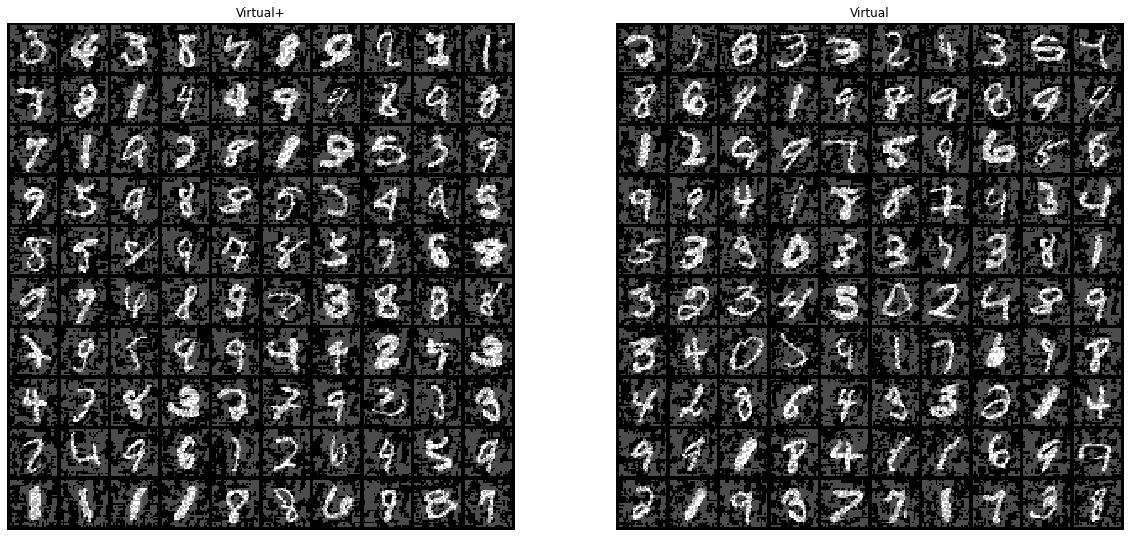

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(121)
show(imgs[0][AlgorithmType.STOCHASTIC_MODIFIED_VIRTUAL.name])
plt.title("Virtual+")
plt.subplot(122)
show(imgs[0][AlgorithmType.STOCHASTIC_VIRTUAL.name])
plt.title("Virtual")

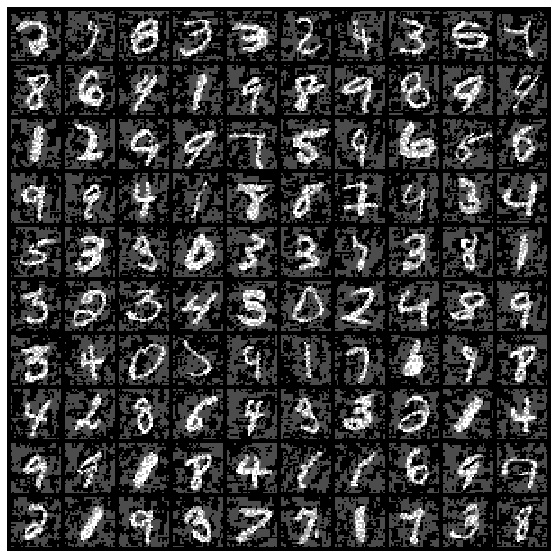

In [16]:
plt.figure(figsize=(10,10))


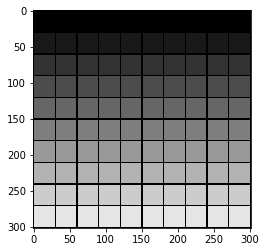

In [37]:
show(img)